In [200]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import os
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

## Transform images

In [201]:
train_transform = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


## Dataloader

In [202]:
data_dir = "C:\\Users\\ritth\\code\\Strive\\Strive-Exercises\\Chapter 03\\06. CNN\\Cat_Dog_data\\Cat_Dog_data"

trainset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
trainloader =  DataLoader(trainset, batch_size=32, shuffle=True)

testset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [203]:
len(trainloader)

704

In [204]:
len(trainset)

22500

In [205]:
trainset.class_to_idx

{'cat': 0, 'dog': 1}

## Visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

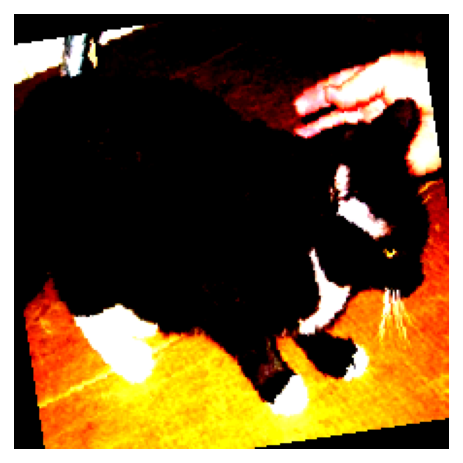

In [206]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

# Run this to test your data loaders
images, labels = next(iter(trainloader))
imshow(images[0], normalize=False)


In [207]:
images.shape

torch.Size([32, 3, 224, 224])

## Pretrained model

In [208]:
model = models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\ritth/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [209]:
inputs = model.fc.in_features
inputs

2048

In [210]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
    ('linear1', nn.Linear(model.fc.in_features, 256)),
    ('relu1', nn.ReLU()),
    ('drop', nn.Dropout(0.2)),
    ('linear2', nn.Linear(256, 2)),
    ('output', nn.LogSoftmax(dim=1))
]))
    
model.fc = classifier

In [212]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Training and Validation

In [213]:
learning_rate = 0.001
epochs = 2

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
benchmark_accuracy = 0.80

for epoch in range(epochs):
    train_batch_accuracies = []
    train_batch_losses = []

    # training
    for x_train_batch, y_train_batch in trainloader:

        optimizer.zero_grad()

        # forward pass
        logits = model(x_train_batch)
        train_preds = torch.argmax(logits.detach(), dim=1)

        # loss
        train_loss = criterion(logits, y_train_batch)
        train_batch_losses.append(train_loss.item())

        # train accuracy
        train_batch_accuracies.append(accuracy_score(y_train_batch, train_preds))

        # backward pass
        train_loss.backward()
        optimizer.step()

        
    train_losses.append(sum(train_batch_losses) / len(trainloader))
    train_accuracies.append(sum(train_batch_accuracies) / len(trainloader))


    # validation
    model.eval()
    with torch.no_grad():
        test_batch_accuracies = []
        test_batch_losses = []

        for x_test_batch, y_test_batch in testloader:

            
            test_logits = model(x_test_batch)
            test_preds = torch.argmax(test_logits, dim=1)
            test_batch_accuracies.append(accuracy_score(y_test_batch, test_preds))
            test_loss = criterion(test_logits, y_test_batch)
            test_batch_losses.append(test_loss.item())

        # mean accuracy for each epoch
        test_accuracies.append(sum(test_batch_accuracies)/len(testloader))

        # mean loss for each epoch
        test_losses.append(sum(test_batch_losses)/len(testloader))

    
        if test_accuracies[-1] > benchmark_accuracy:
            torch.save(model.state_dict(), './model.pth')
            benchmark_accuracy = test_accuracies[-1]
        
        model.train()


# Plots
x_epochs = list(range(epochs))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, train_losses, marker='o', label='train')
plt.plot(x_epochs, test_losses, marker='o', label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, train_accuracies, marker='o', label='train')
plt.plot(x_epochs, test_accuracies, marker='o', label='test')
plt.axhline(benchmark_accuracy, c='grey', ls='--',
            label=f'benchmark_accuracy({benchmark_accuracy :.2f})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./learning_curve.png', dpi = 200)

plt.show()
